In [1]:
import pandas as pd
import numpy as np
import time
from datetime import timedelta,datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import CubicSpline, make_splrep
from data_generation import data_split
from features_generation import calculate_deviations

## Данные

Расшифровка данных

In [4]:
df1=pd.read_pickle('ncrptd.pkl')
df1.reset_index(inplace = True)

df=pd.DataFrame(columns = ['well_id', 'param_id', 'tm_time','tm_value'])
df['well_id'] = df1['wd']+2024
df['param_id'] = df1['pd']+1703
df['tm_time'] = df1['tt']+timedelta(days=10000)
df['tm_value'] = df1['tv']/1.1

print(df['tm_time'].min(), df['tm_time'].max())

2024-04-01 00:00:00 2024-04-02 00:00:00


In [6]:
data_ri = pd.read_pickle('ri.pkl')
df_ri = pd.DataFrame(columns = ['well_id', 'regime_mode', 'data','pid_name', 'is_pid_adj', 'pid_adj_min_current_freq', 'pid_adj_max_current_freq'])
df_ri['well_id'] = data_ri['wd']+2024
df_ri['data'] = data_ri['rd'] + timedelta(days = 10000)
df_ri['regime_mode'] = data_ri['regime_mode']
df_ri['pid_name'] = data_ri['pid_name']
df_ri['is_pid_adj'] = data_ri['is_pid_adj']
df_ri['pid_adj_min_current_freq'] = data_ri['pid_adj_min_current_freq']
df_ri['pid_adj_max_current_freq'] = data_ri['pid_adj_max_current_freq']
df_ri

,well_id,regime_mode,data,pid_name,is_pid_adj,pid_adj_min_current_freq,pid_adj_max_current_freq
0,2270005300,ПДФ,2023-06-01,None,0.0,None,None
1,2270010500,ПДФ,2023-09-03,None,0.0,None,None
2,2270011311,ПДФ,2022-12-19,None,0.0,None,None
3,2270011401,ПДФ,2022-04-11,None,0.0,None,None
4,2270011508,ПДФ,2023-11-01,"Сила тока, А",0.0,43.0,60.0
...,...,...,...,...,...,...,...
3627,9880203000,ПКВ,2024-02-18,"Сила тока, А",1.0,49.0,55.0
3628,9880203600,ПДФ,2024-03-05,"Сила тока, А",1.0,50.0,55.0
3629,9880203700,ПКВ,2024-03-23,None,0.0,None,None
3630,9880203800,АПВ,2024-03-30,"Загрузка ПЭД, %",1.0,50.0,55.0


In [8]:
data_ri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3632 entries, 0 to 3631
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   work_time                   3251 non-null   object        
 1   stop_time                   3247 non-null   object        
 2   regime_mode                 3632 non-null   object        
 3   pid_name                    2060 non-null   object        
 4   is_pid_adj                  3632 non-null   object        
 5   pid_adj_min_current_freq    2058 non-null   object        
 6   pid_adj_max_current_freq    2058 non-null   object        
 7   pid_adj_freq_change_rate    2048 non-null   object        
 8   pid_adj_setting_value       2057 non-null   object        
 9   jog_min_current_freq        52 non-null     object        
 10  jog_max_current_freq        52 non-null     object        
 11  jog_freq_change_rate        51 non-null     object      

Выбор ПДФ скважины

In [9]:
df_ri = df_ri.query('regime_mode == "ПДФ"')
df_ri

,well_id,regime_mode,data
0,2270005300,ПДФ,2023-06-01
1,2270010500,ПДФ,2023-09-03
2,2270011311,ПДФ,2022-12-19
3,2270011401,ПДФ,2022-04-11
4,2270011508,ПДФ,2023-11-01
...,...,...,...
3623,9880105100,ПДФ,2023-04-03
3624,9880106000,ПДФ,2023-05-12
3626,9880200103,ПДФ,2022-10-03
3628,9880203600,ПДФ,2024-03-05


## Фичи

Выбор скважины по ее id, указание какие параметры выбрать, указание размера пакета и обрезки слева

In [12]:
list_of_dfs = data_split(df, well_id_int=9880203600, param_id_list=[188,200], package_size=10000, leftcut=0)

C:\Users\Pro10\Desktop\data_generation.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


Расчет статистик для каждого параметра и отклонений от них для каждой точки

In [15]:
result_df = calculate_deviations(list_of_dfs, dict_values = {188: [50,200], 200: [20, 55]})

result_df[-1][0]

,188_Value,188_Deviation from Mean,188_Deviation from Weighted Mean,188_Deviation from Q1,188_Deviation from Median,188_Deviation from Q3,188_Deviation from Previous Value,188_Deviation from Set Min Value,188_Deviation from Set Max Value,200_Value,200_Deviation from Mean,200_Deviation from Weighted Mean,200_Deviation from Q1,200_Deviation from Median,200_Deviation from Q3,200_Deviation from Previous Value,200_Deviation from Set Min Value,200_Deviation from Set Max Value
tm_time,,,,,,,,,,,,,,,,,,
2024-04-01 00:06:14,54.310000,0.094939,0.111726,0.138800,0.101750,0.039763,NaN,4.310000,-145.690000,61.0,0.175423,0.193371,0.286667,0.0,0.0,NaN,41.0,6.0
2024-04-01 00:06:15,54.309933,0.094872,0.111660,0.138733,0.101683,0.039696,-0.000067,4.309933,-145.690067,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 00:06:16,54.309867,0.094806,0.111593,0.138667,0.101617,0.039629,-0.000067,4.309867,-145.690133,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 00:06:17,54.309800,0.094739,0.111526,0.138600,0.101550,0.039563,-0.000067,4.309800,-145.690200,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 00:06:18,54.309733,0.094672,0.111460,0.138533,0.101483,0.039496,-0.000067,4.309733,-145.690267,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01 23:53:05,54.109933,-0.105128,-0.088340,-0.061267,-0.098317,-0.160304,0.000017,4.109933,-145.890067,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 23:53:06,54.109950,-0.105111,-0.088324,-0.061250,-0.098300,-0.160287,0.000017,4.109950,-145.890050,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0
2024-04-01 23:53:07,54.109967,-0.105094,-0.088307,-0.061233,-0.098283,-0.160271,0.000017,4.109967,-145.890033,61.0,0.175423,0.193371,0.286667,0.0,0.0,0.0,41.0,6.0


# Test Data

Создание тестового датасета для одного параметра

In [20]:
df = pd.DataFrame()
df['188_Value'] = result_df[-1][0]['188_Value']
df

,188_Value
tm_time,
2024-04-01 00:06:14,54.310000
2024-04-01 00:06:15,54.309933
2024-04-01 00:06:16,54.309867
2024-04-01 00:06:17,54.309800
2024-04-01 00:06:18,54.309733
...,...
2024-04-01 23:53:05,54.109933
2024-04-01 23:53:06,54.109950
2024-04-01 23:53:07,54.109967


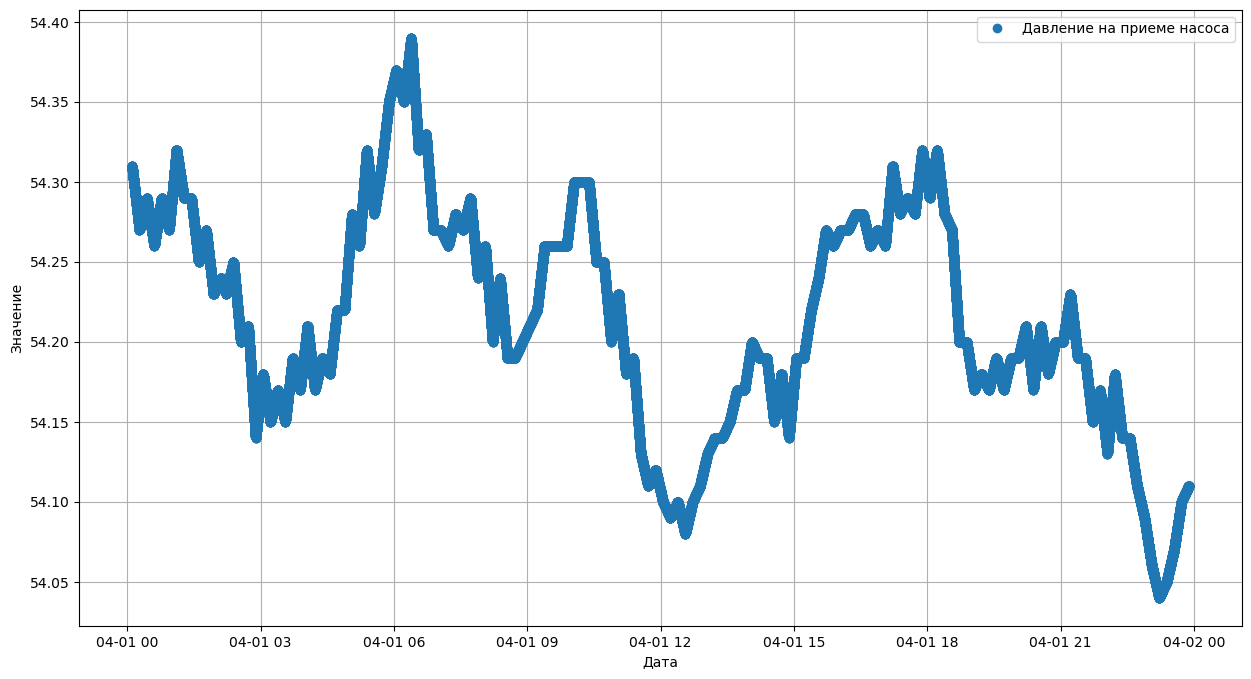

In [22]:
# Построение графика
plt.figure(figsize=(15, 8))
plt.plot(df, 'o', label='Давление на приеме насоса')


# Настройки графика

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.xticks() 
plt.yticks() 
plt.grid(True)

# Показ графика
plt.show()

In [24]:
x = df.index.values
y = df['188_Value'].values

### Сегментация, трендирование и отрисовка для ПДФ

calculate_from_zero_to_point_paket, calculate_interval_paket - функции для разбиения ряда определенным образом (от 0 значения ряда до i*interval и на отдельные интервалы соответственно) и подсчет для каждого разбиения тренда методом линейной регрессии или сплайна

draw_calculations - функция отрисовки


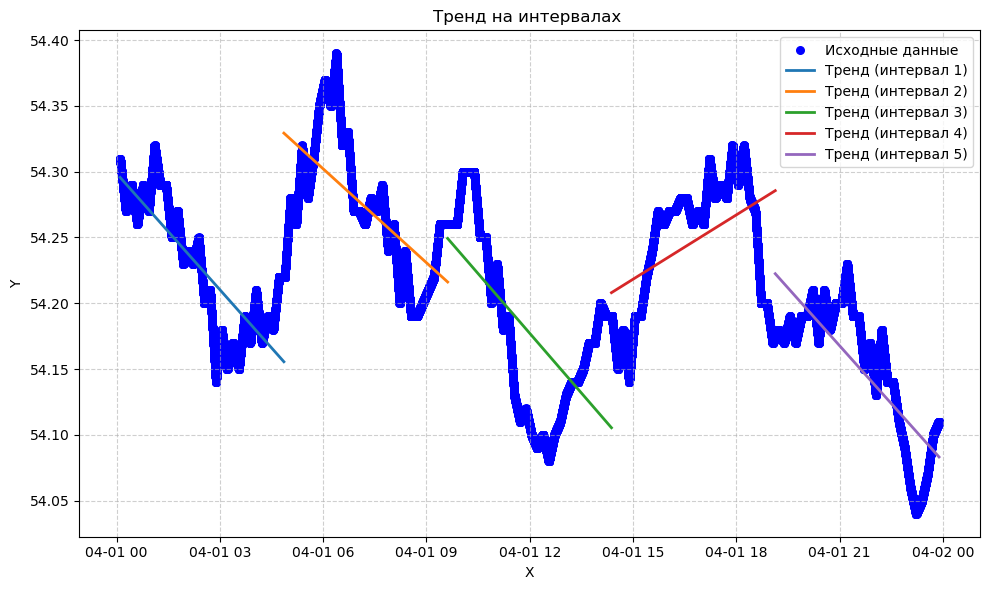

In [28]:
#интервальный пакет трендированный линейной регрессией, отрисовка matplot


from trend_calculations import calculate_from_zero_to_point_paket, calculate_interval_paket
from drawning import draw_calculations
#array_dfs = calculate_from_zero_to_point_paket(x, y, interval = len(x)//10, method='Bspline')
array_dfs = calculate_interval_paket(x, y, interval = len(x)//5, method= 'linreg')
draw_calculations(x, y, array_dfs, method = 'mat')

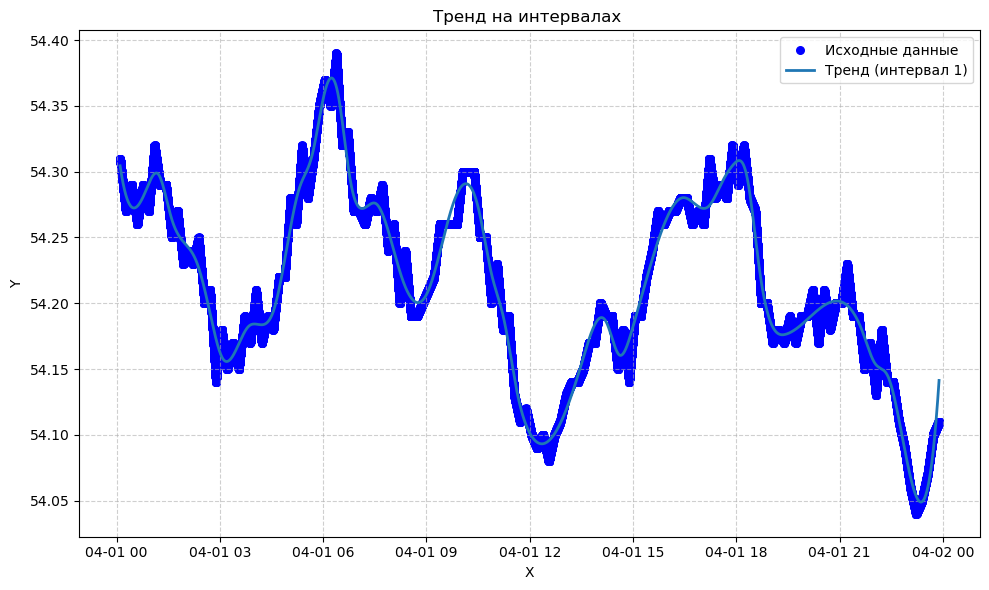

In [29]:
#интервальный пакет трендированный сплайном, отрисовка matplot


from trend_calculations import calculate_from_zero_to_point_paket, calculate_interval_paket
from drawning import draw_calculations
#array_dfs = calculate_from_zero_to_point_paket(x, y, interval = len(x)//10, method='Bspline')
array_dfs = calculate_interval_paket(x, y, interval = len(x), method= 'Bspline')
draw_calculations(x, y, array_dfs, method = 'mat')

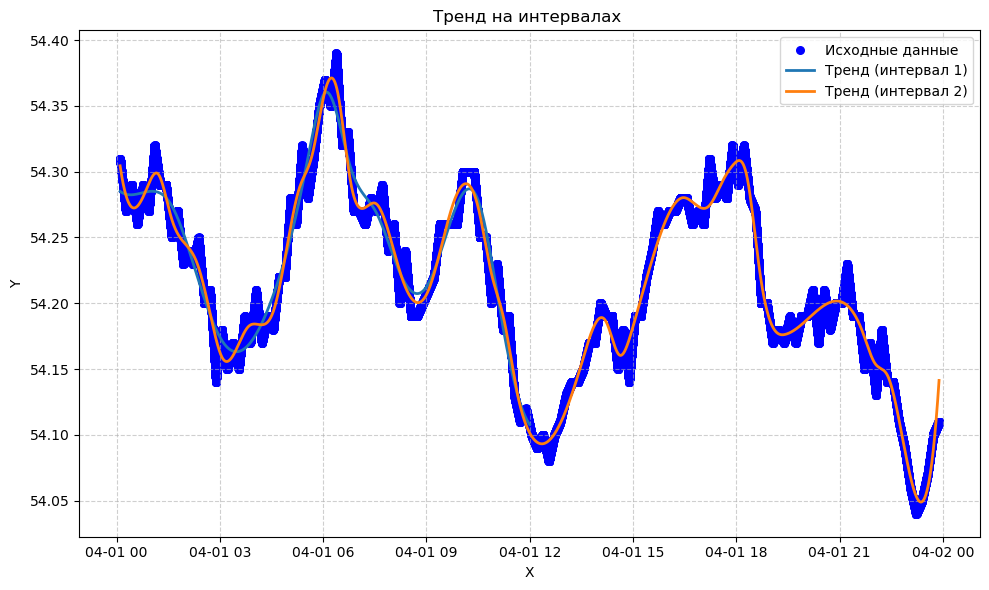

In [39]:
# _from_zero_to_point_ пакет трендированный сплайном, отрисовка matplot


from trend_calculations import calculate_from_zero_to_point_paket, calculate_interval_paket
from drawning import draw_calculations
array_dfs = calculate_from_zero_to_point_paket(x, y, interval = len(x)//2, method='Bspline')
#array_dfs = calculate_interval_paket(x, y, interval = len(x), method= 'Bspline')
draw_calculations(x, y, array_dfs, method = 'mat')

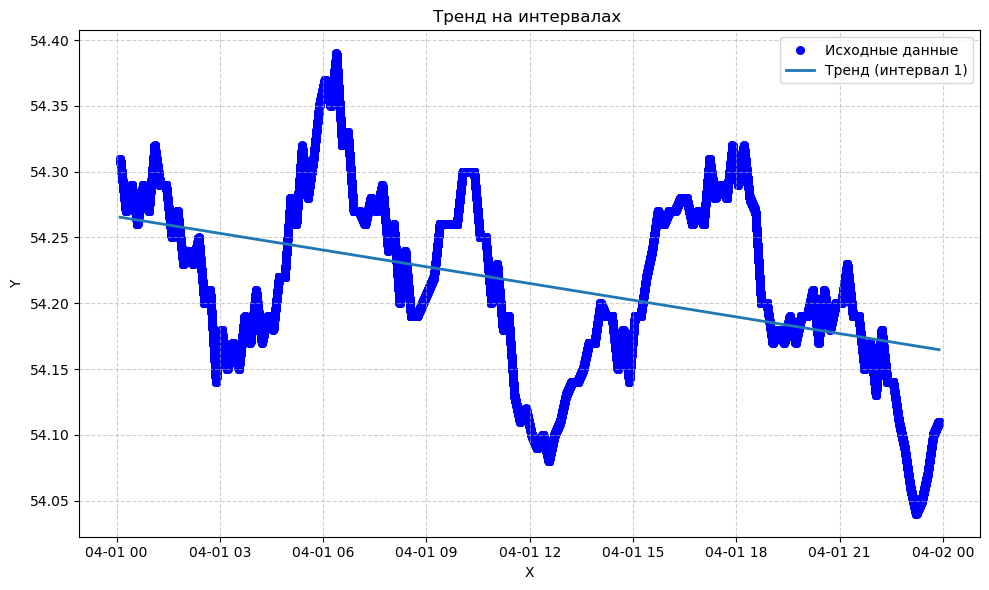

In [43]:
# _from_zero_to_point_ пакет трендированный линейной регрессии, отрисовка matplot


from trend_calculations import calculate_from_zero_to_point_paket, calculate_interval_paket
from drawning import draw_calculations
array_dfs = calculate_from_zero_to_point_paket(x, y, interval = len(x), method='linreg')
#array_dfs = calculate_interval_paket(x, y, interval = len(x), method= 'Bspline')
draw_calculations(x, y, array_dfs, method = 'mat')

# ПКВ сегментация

In [10]:
df_ri = df_ri.query('regime_mode == "ПКВ"')
df_ri

,well_id,regime_mode,data,pid_name,is_pid_adj,pid_adj_min_current_freq,pid_adj_max_current_freq
21,2270024100,ПКВ,2024-03-26,None,0.0,None,None
37,2270036800,ПКВ,2022-11-29,None,0.0,None,None
39,2270042700,ПКВ,2023-10-05,None,0.0,None,None
49,2270070800,ПКВ,2022-11-16,None,0.0,None,None
60,2270083800,ПКВ,2023-09-21,"Сила тока, А",0.0,47.0,58.0
...,...,...,...,...,...,...,...
3615,9880101900,ПКВ,2024-04-02,"Загрузка ПЭД, %",0.0,48.0,54.0
3621,9880102900,ПКВ,2024-03-18,"Сила тока, А",0.0,35.0,54.0
3625,9880106200,ПКВ,2024-02-01,"Сила тока, А",1.0,52.0,60.0
3627,9880203000,ПКВ,2024-02-18,"Сила тока, А",1.0,49.0,55.0


In [12]:
df_ri.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 21 to 3629
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   well_id                   1938 non-null   int64         
 1   regime_mode               1938 non-null   object        
 2   data                      1938 non-null   datetime64[ns]
 3   pid_name                  1414 non-null   object        
 4   is_pid_adj                1938 non-null   object        
 5   pid_adj_min_current_freq  1413 non-null   object        
 6   pid_adj_max_current_freq  1413 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 121.1+ KB


In [39]:
df_ri1 = df_ri[df_ri['pid_adj_min_current_freq'].isnull() == False]

In [45]:
df_ri1

,well_id,regime_mode,data,pid_name,is_pid_adj,pid_adj_min_current_freq,pid_adj_max_current_freq
60,2270083800,ПКВ,2023-09-21,"Сила тока, А",0.0,47.0,58.0
105,2270202400,ПКВ,2022-10-27,"Сила тока, А",0.0,90.0,110.0
153,2280001900,ПКВ,2023-12-08,"Сила тока, А",0.0,48.0,58.0
188,2280010000,ПКВ,2023-09-05,"Сила тока, А",0.0,120.0,195.0
189,2280010100,ПКВ,2024-04-01,"Сила тока, А",0.0,46.0,55.0
...,...,...,...,...,...,...,...
3613,9880100403,ПКВ,2023-12-18,"Сила тока, А",0.0,97.0,110.0
3615,9880101900,ПКВ,2024-04-02,"Загрузка ПЭД, %",0.0,48.0,54.0
3621,9880102900,ПКВ,2024-03-18,"Сила тока, А",0.0,35.0,54.0
3625,9880106200,ПКВ,2024-02-01,"Сила тока, А",1.0,52.0,60.0


In [170]:
for i, name in enumerate(df_ri['well_id']):
    if name== 6110299100:
        print(i, name)

1813 6110299100


In [47]:
list_of_dfs = data_split(df, well_id_int=6110299100, param_id_list=[220], package_size=10000, leftcut=0)

C:\Users\Pro10\Desktop\data_generation.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


In [49]:
result_df = calculate_deviations(list_of_dfs, dict_values = {220: [0,2000]})

result_df[-1][0]

,220_Value,220_Deviation from Mean,220_Deviation from Weighted Mean,220_Deviation from Q1,220_Deviation from Median,220_Deviation from Q3,220_Deviation from Previous Value,220_Deviation from Set Min Value,220_Deviation from Set Max Value
tm_time,,,,,,,,,
2024-04-01 00:00:03,52.0,34.782927,34.598273,52.0,52.0,0.0,NaN,52.0,-1948.0
2024-04-01 00:00:04,52.0,34.782927,34.598273,52.0,52.0,0.0,0.0,52.0,-1948.0
2024-04-01 00:00:05,52.0,34.782927,34.598273,52.0,52.0,0.0,0.0,52.0,-1948.0
2024-04-01 00:00:06,52.0,34.782927,34.598273,52.0,52.0,0.0,0.0,52.0,-1948.0
2024-04-01 00:00:07,52.0,34.782927,34.598273,52.0,52.0,0.0,0.0,52.0,-1948.0
...,...,...,...,...,...,...,...,...,...
2024-04-01 23:59:36,52.0,34.782927,34.598273,52.0,52.0,0.0,0.0,52.0,-1948.0
2024-04-01 23:59:37,52.0,34.782927,34.598273,52.0,52.0,0.0,0.0,52.0,-1948.0
2024-04-01 23:59:38,52.0,34.782927,34.598273,52.0,52.0,0.0,0.0,52.0,-1948.0


In [51]:
df = pd.DataFrame()
df['220_Value'] = result_df[-1][0]['220_Value']
df

,220_Value
tm_time,
2024-04-01 00:00:03,52.0
2024-04-01 00:00:04,52.0
2024-04-01 00:00:05,52.0
2024-04-01 00:00:06,52.0
2024-04-01 00:00:07,52.0
...,...
2024-04-01 23:59:36,52.0
2024-04-01 23:59:37,52.0
2024-04-01 23:59:38,52.0


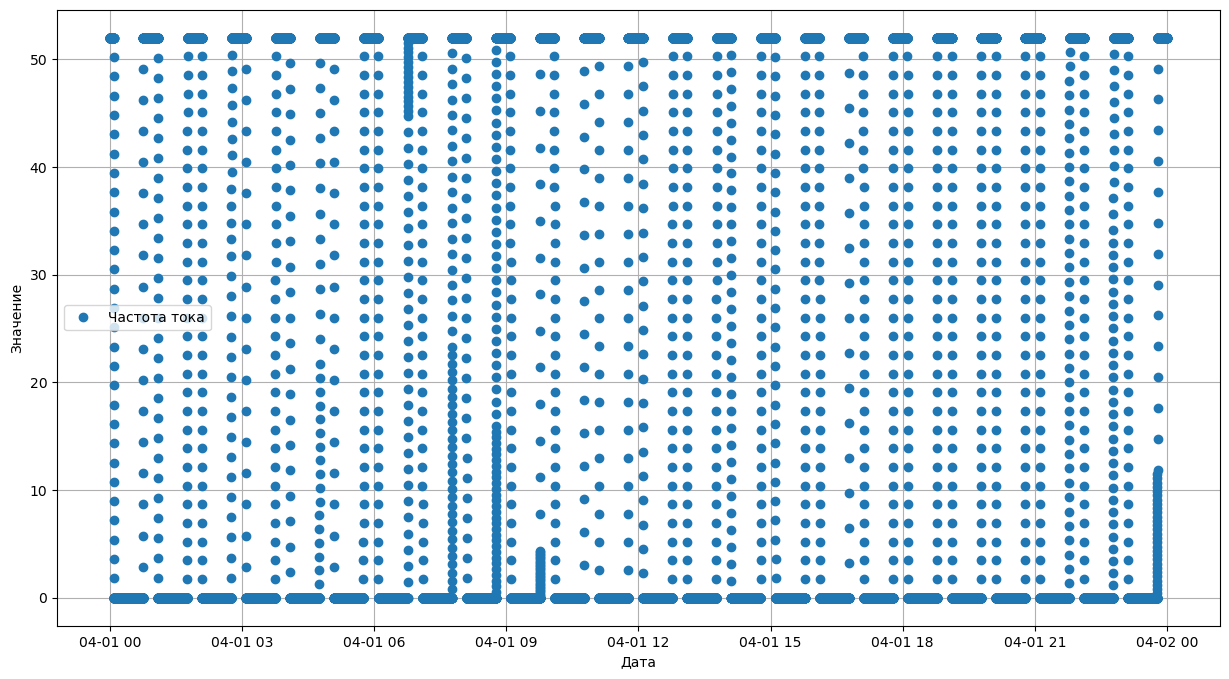

In [53]:
# Построение графика
plt.figure(figsize=(15, 8))
plt.plot(df, 'o', label='Частота тока')


# Настройки графика

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.xticks() 
plt.yticks() 
plt.grid(True)

# Показ графика
plt.show()

In [55]:
x = df.index.values
y = df['220_Value'].values

In [57]:
import pandas as pd

def determine_type(value, prev_value, max_work_value, min_work_value):
    if value == 0:
        return 'zero'
    elif min_work_value <= value <= max_work_value:
        return 'work'
    else:
        if prev_value is None:
            return 'unknown'
        else:
            return 'up' if value > prev_value else 'down'

def PKV_segmentation(df, max_work_value, min_work_value):
    results = []
    deferred_point = None  # (value, time, type)
    prev_value = None
    prev_time = None
    
    for idx, point_value in df.iloc[:, 0].items():
        if deferred_point:
            d_value, d_time, d_type = deferred_point
            resolved_type = 'up' if point_value > d_value else 'down'
            point_type = determine_type(point_value, d_value, max_work_value, min_work_value)
            # Если тип совпадает с текущим, расширяем сегмент
            if resolved_type == point_type:
                results.append({
                    'start': d_time,
                    'end': idx,
                    'duration': idx - d_time,
                    'type': point_type
                })
            else: # Иначе создаем два отдельных сегмента
                results.append({
                    'start': d_time,
                    'end': d_time,
                    'duration': pd.Timedelta(0),
                    'type': resolved_type
                })
                results.append({
                    'start': idx,
                    'end': idx,
                    'duration': pd.Timedelta(0),
                    'type': point_type
                })
            deferred_point = None 
            prev_value = point_value
            prev_time = idx
            continue
        # Определение типа точки    
        point_type = determine_type(point_value, prev_value, max_work_value, min_work_value)
        # Обработка типа точки unknow
        if point_type == 'unknown':
            deferred_point = (point_value, idx, point_type)
        else: # Если тип есть
            if not results: # Если первая точка
                results.append({
                    'start': idx,
                    'end': idx,
                    'duration': pd.Timedelta(0),
                    'type': point_type
                })
            else:  
                last_segment = results[-1] # Тот же тип
                if last_segment['type'] == point_type:
                    last_segment['end'] = idx
                    last_segment['duration'] = idx - last_segment['start']
                else: 
                    results.append({
                        'start': idx,
                        'end': idx,
                        'duration': pd.Timedelta(0),
                        'type': point_type
                    })
        prev_value = point_value
        prev_time = idx
    
    if deferred_point:
        _, d_time, _ = deferred_point
        results.append({
            'start': d_time,
            'end': d_time,
            'duration': pd.Timedelta(0),
            'type': 'unknown'
        })
    
    return pd.DataFrame(results)

In [59]:
%%time
dat = pd.DataFrame({'value': y}, index=x)
result = PKV_segmentation(dat, 55, 49)
print(result)

                 start                 end        duration  type
0  2024-04-01 00:00:03 2024-04-01 00:05:04 0 days 00:05:01  work
1  2024-04-01 00:05:05 2024-04-01 00:05:31 0 days 00:00:26  down
2  2024-04-01 00:05:32 2024-04-01 00:45:18 0 days 00:39:46  zero
3  2024-04-01 00:45:19 2024-04-01 00:45:34 0 days 00:00:15    up
4  2024-04-01 00:45:35 2024-04-01 01:05:19 0 days 00:19:44  work
..                 ...                 ...             ...   ...
92 2024-04-01 22:47:20 2024-04-01 23:06:41 0 days 00:19:21  work
93 2024-04-01 23:06:42 2024-04-01 23:07:09 0 days 00:00:27  down
94 2024-04-01 23:07:10 2024-04-01 23:46:40 0 days 00:39:30  zero
95 2024-04-01 23:46:41 2024-04-01 23:47:22 0 days 00:00:41    up
96 2024-04-01 23:47:23 2024-04-01 23:59:40 0 days 00:12:17  work

[97 rows x 4 columns]
CPU times: total: 266 ms
Wall time: 257 ms


In [139]:
data

,value
2024-04-01 00:00:03,52.0
2024-04-01 00:00:04,52.0
2024-04-01 00:00:05,52.0
2024-04-01 00:00:06,52.0
2024-04-01 00:00:07,52.0
...,...
2024-04-01 23:59:36,52.0
2024-04-01 23:59:37,52.0
2024-04-01 23:59:38,52.0
2024-04-01 23:59:39,52.0


In [61]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_original_points_optimized(original_df, segments_df, high, low):
    """
    Оптимизированная отрисовка точек через сегменты.
    
    Параметры:
        original_df (pd.DataFrame): Исходные данные (индекс - время, колонка 'value')
        segments_df (pd.DataFrame): Сегменты с колонками ['start', 'end', 'type']
        low (float): Нижняя граница work
        high (float): Верхняя граница work
    """
    # Цвета для типов
    color_map = {
        'work': 'green',
        'down': 'red',
        'up': 'blue',
        'zero': 'black',
        'unknown': 'gray'
    }
    
    fig, ax = plt.subplots(figsize=(25, 10))
    
    # Сортируем сегменты по времени
    segments_df = segments_df.sort_values('start')
    
    # Создаем массив цветов (по умолчанию - unknown)
    colors = pd.Series('gray', index=original_df.index)
    
    # Проходим по сегментам
    for _, seg in segments_df.iterrows():
        start, end, seg_type = seg['start'], seg['end'], seg['type']
        
        # Находим все точки в этом сегменте
        mask = (original_df.index >= start) & (original_df.index <= end)
        colors.loc[mask] = seg_type
    
    # Отрисовываем все точки одним вызовом
    ax.scatter(
        x=original_df.index,
        y=original_df['value'],
        c=colors.map(color_map),
        s=50,
        alpha=0.7
    )
    
    # Подсветка диапазона work
    ax.axhspan(low, high, color='green', alpha=0.1, label='Work range')
    
    # Настройки графика
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title('Отрисовка по сегментам')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Легенда
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', 
                     markersize=15, markerfacecolor=color, label=label)
                    for label, color in color_map.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

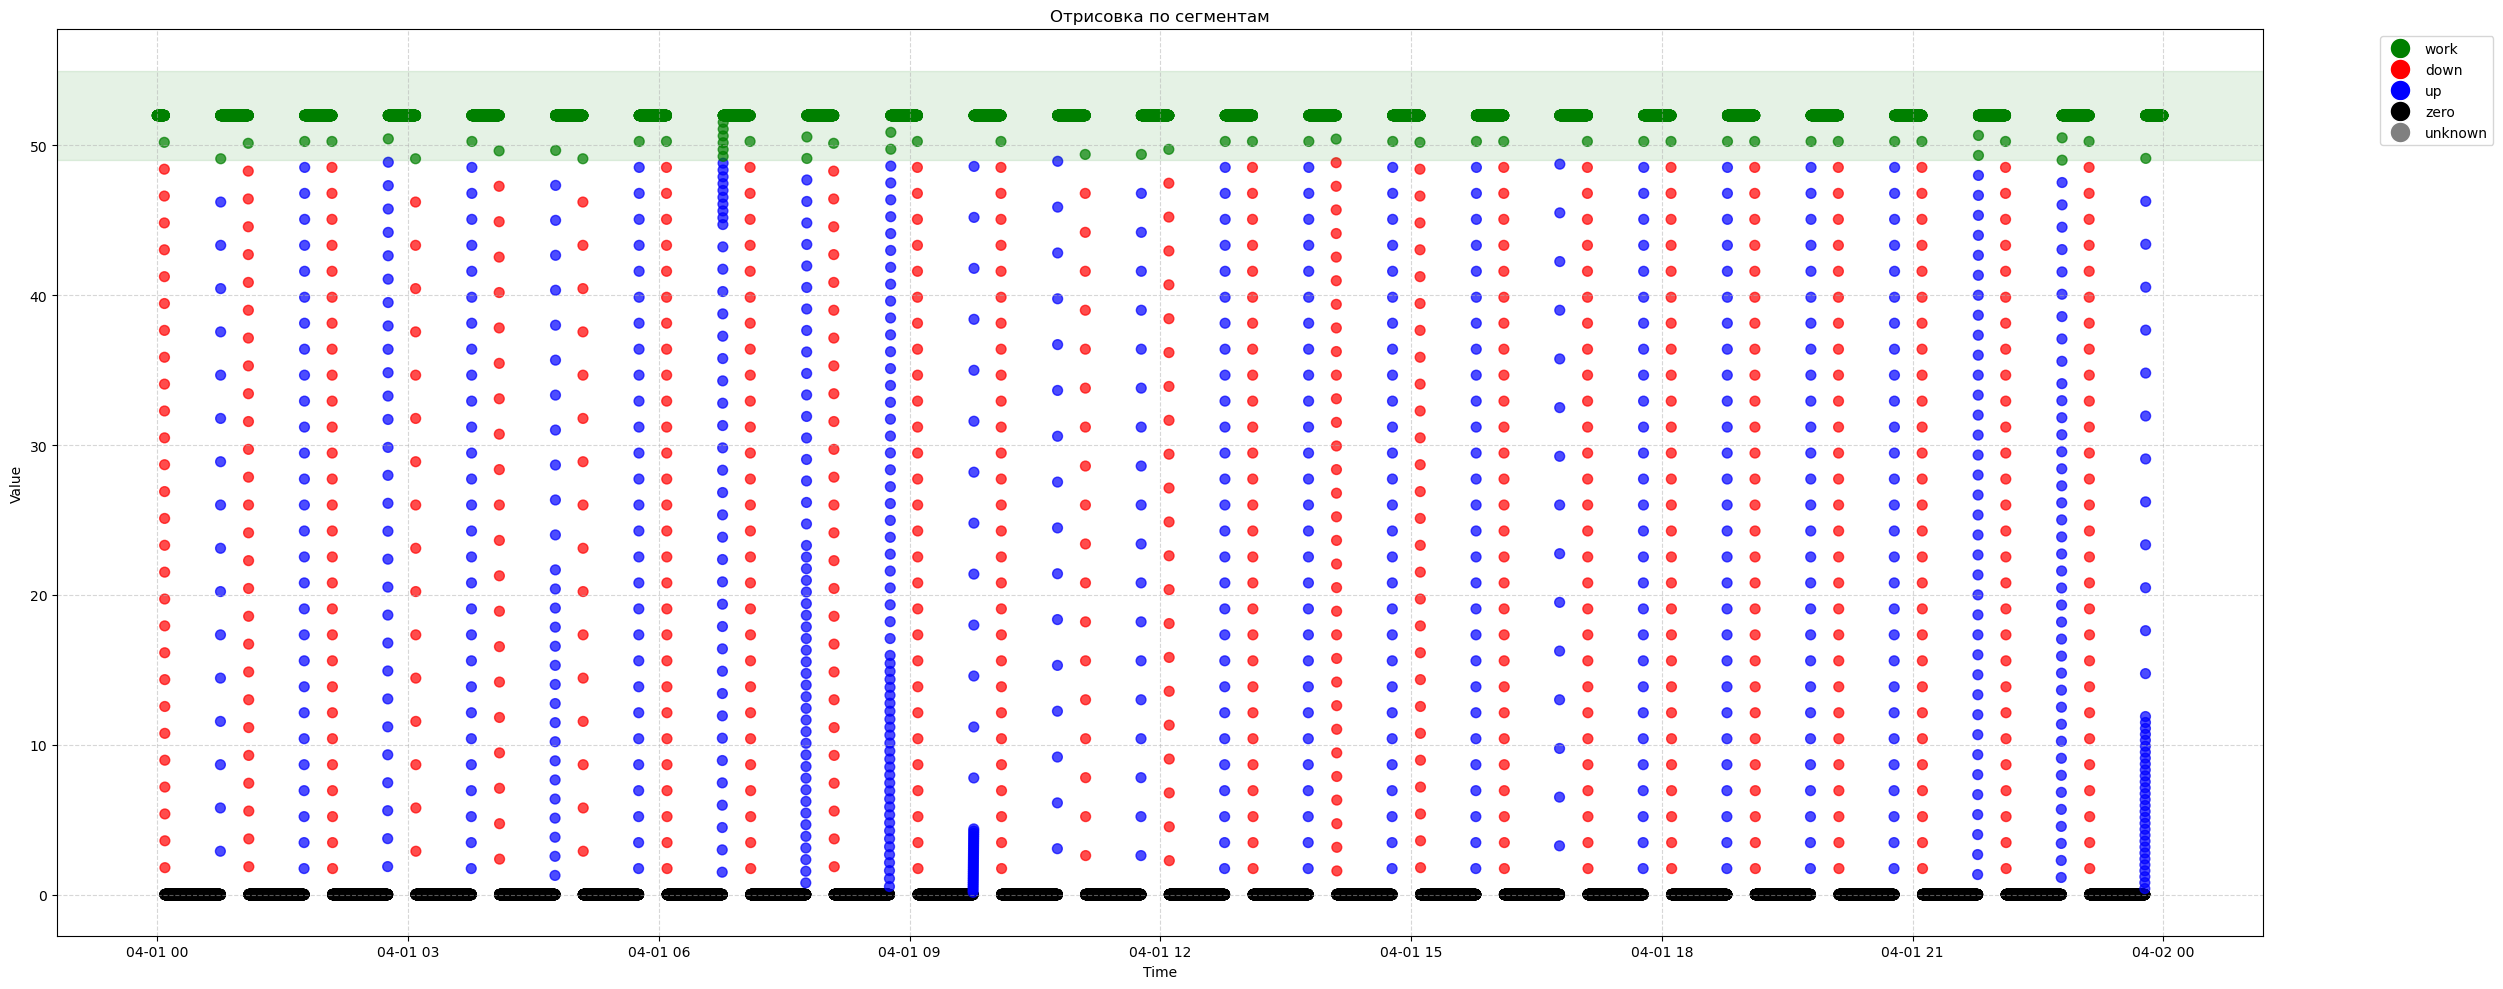

CPU times: total: 1.77 s
Wall time: 1.76 s


In [67]:
%%time
plot_original_points_optimized(dat, result, 55, 49)

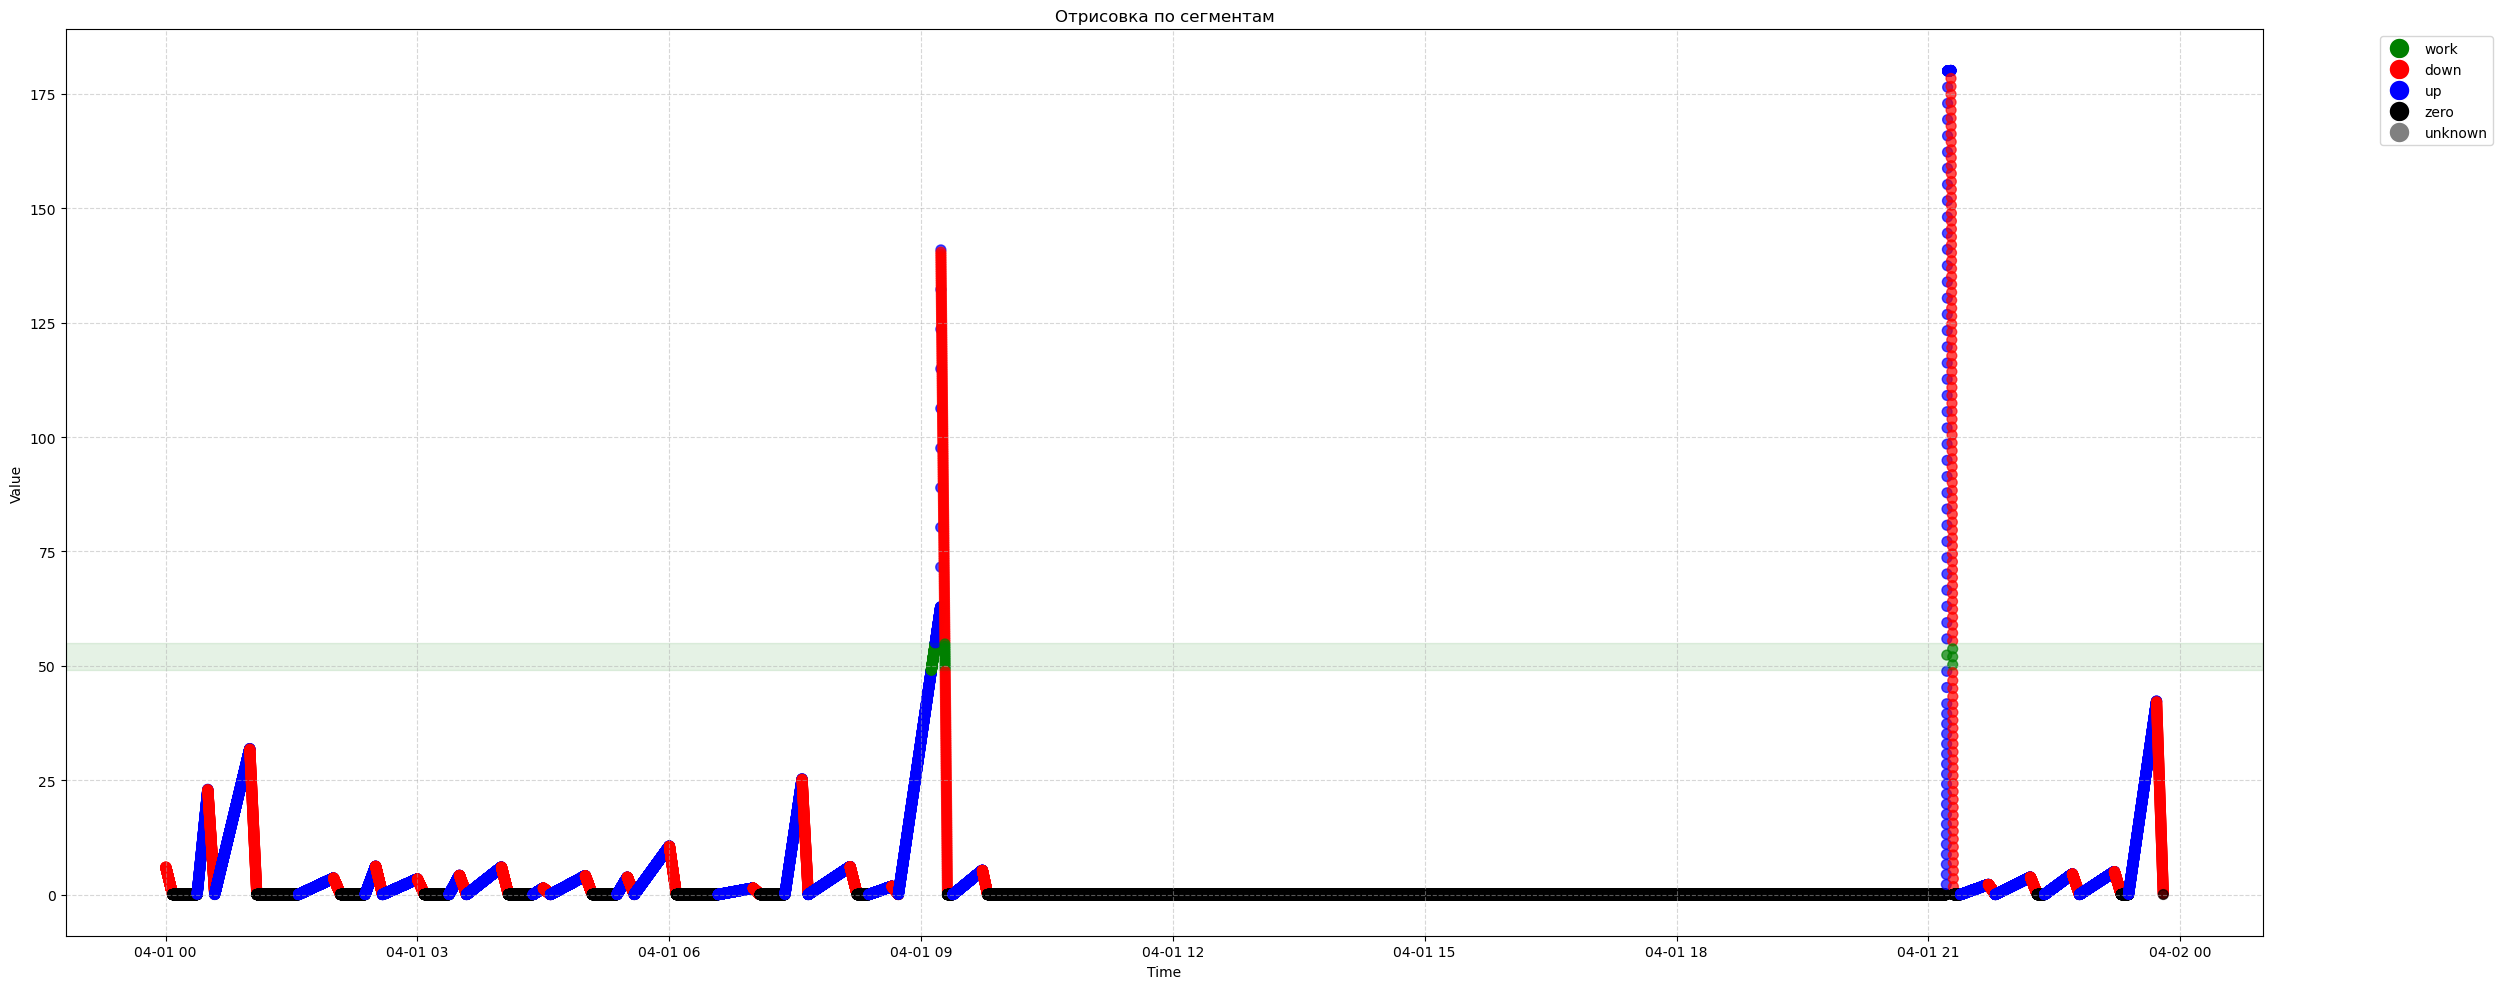

In [220]:
def PKV(df_ri, )

list_of_dfs = data_split(df, well_id_int=2270024100	, param_id_list=[220], package_size=10000, leftcut=0)
result_df = calculate_deviations(list_of_dfs, dict_values = {220: [0,2000]})
df2 = pd.DataFrame()
df2['220_Value'] = result_df[-1][0]['220_Value']
x = df2.index.values
y = df2['220_Value'].values
dat = pd.DataFrame({'value': y}, index=x)
result = PKV_segmentation(dat, 55, 49)
plot_original_points_optimized(dat, result, 49,  55)

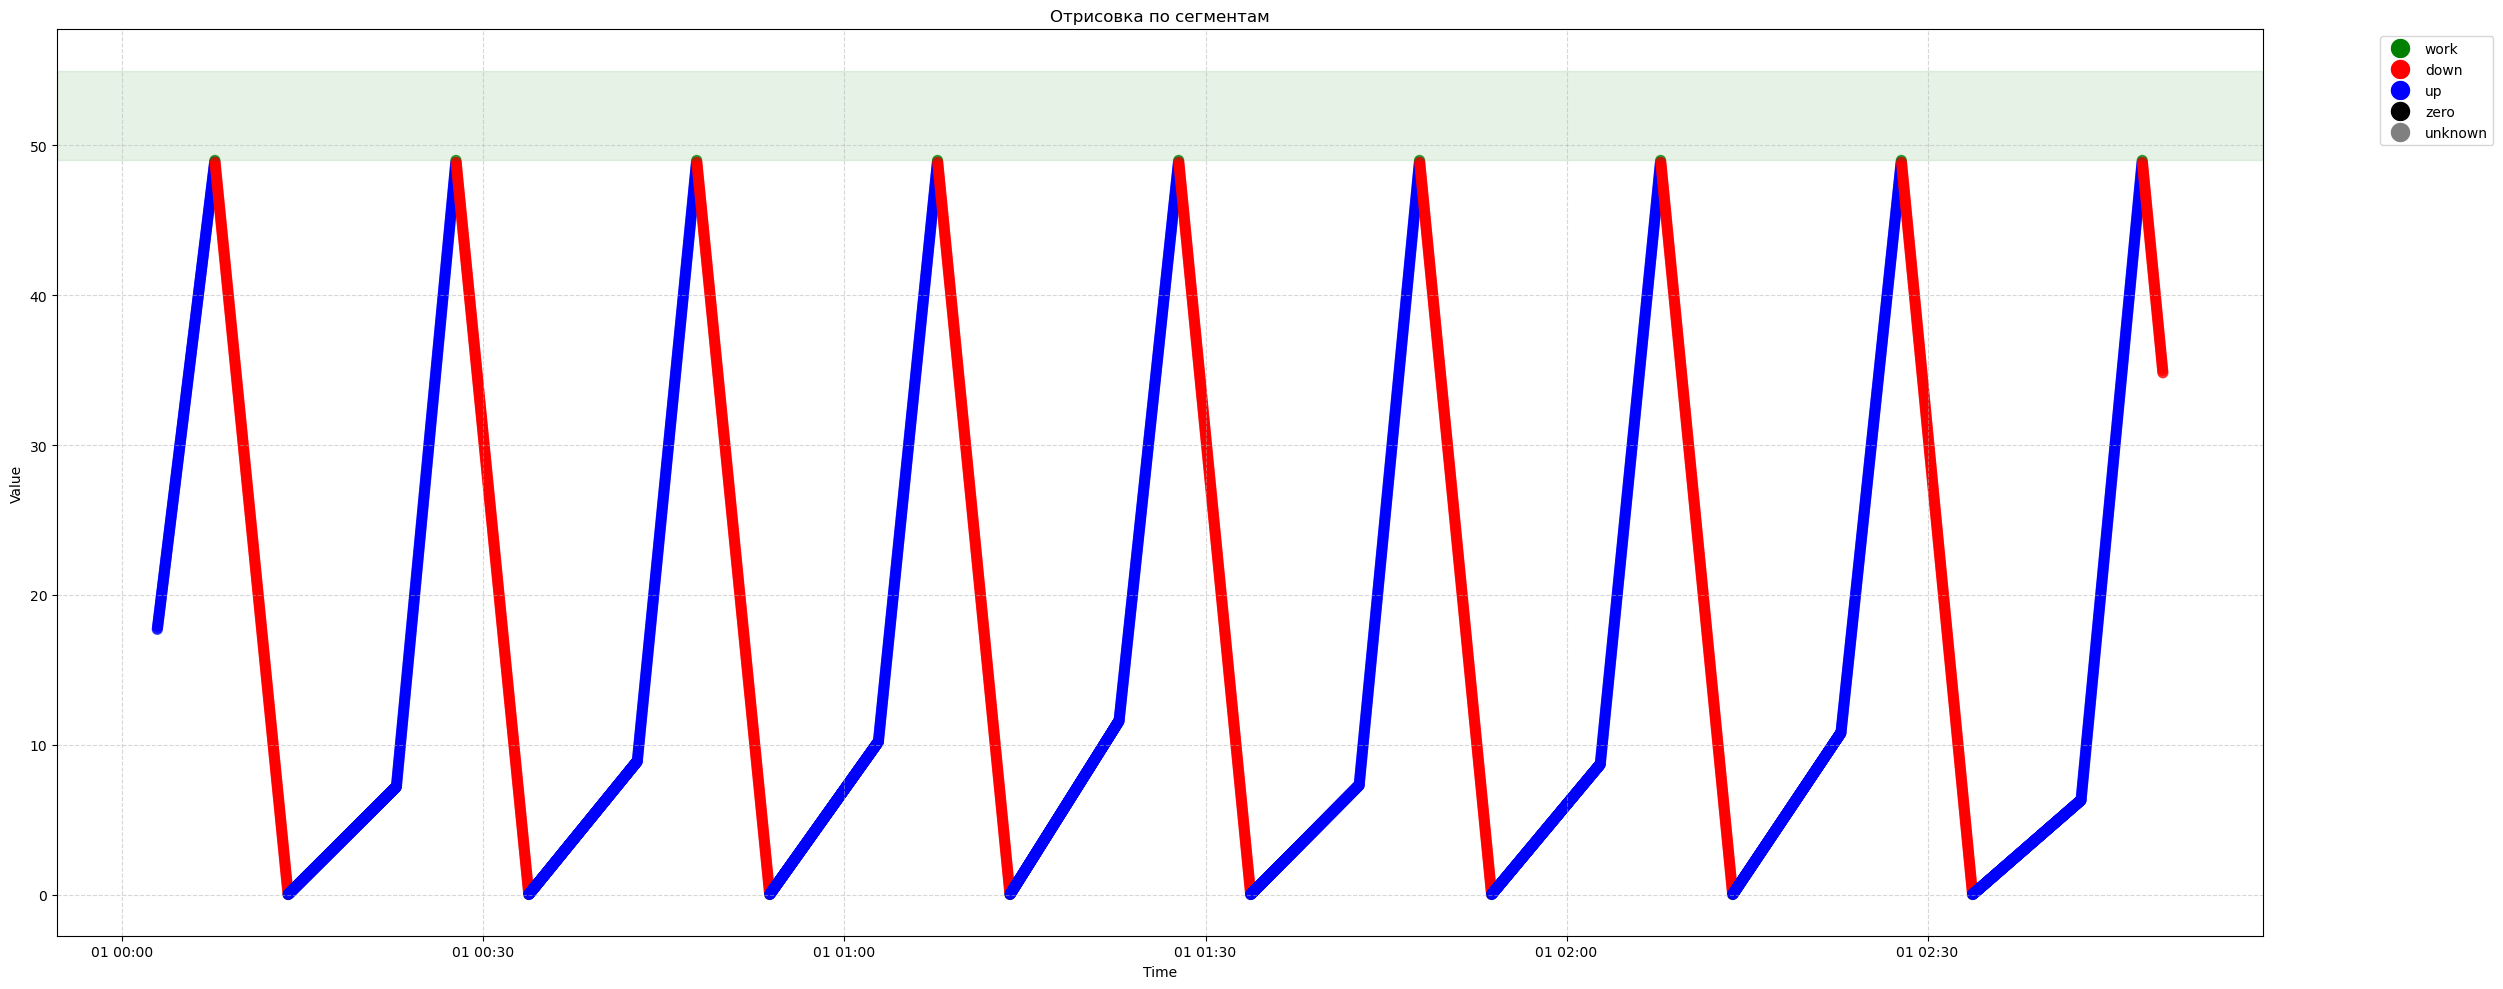

In [222]:
list_of_dfs = data_split(df, well_id_int=2270042700, param_id_list=[220], package_size=10000, leftcut=0)
result_df = calculate_deviations(list_of_dfs, dict_values = {220: [0,2000]})
df2 = pd.DataFrame()
df2['220_Value'] = result_df[-1][0]['220_Value'][:10000]
x = df2.index.values
y = df2['220_Value'].values
dat = pd.DataFrame({'value': y}, index=x)
result = PKV_segmentation(dat, 55, 49)
plot_original_points_optimized(dat, result, 49,  55)

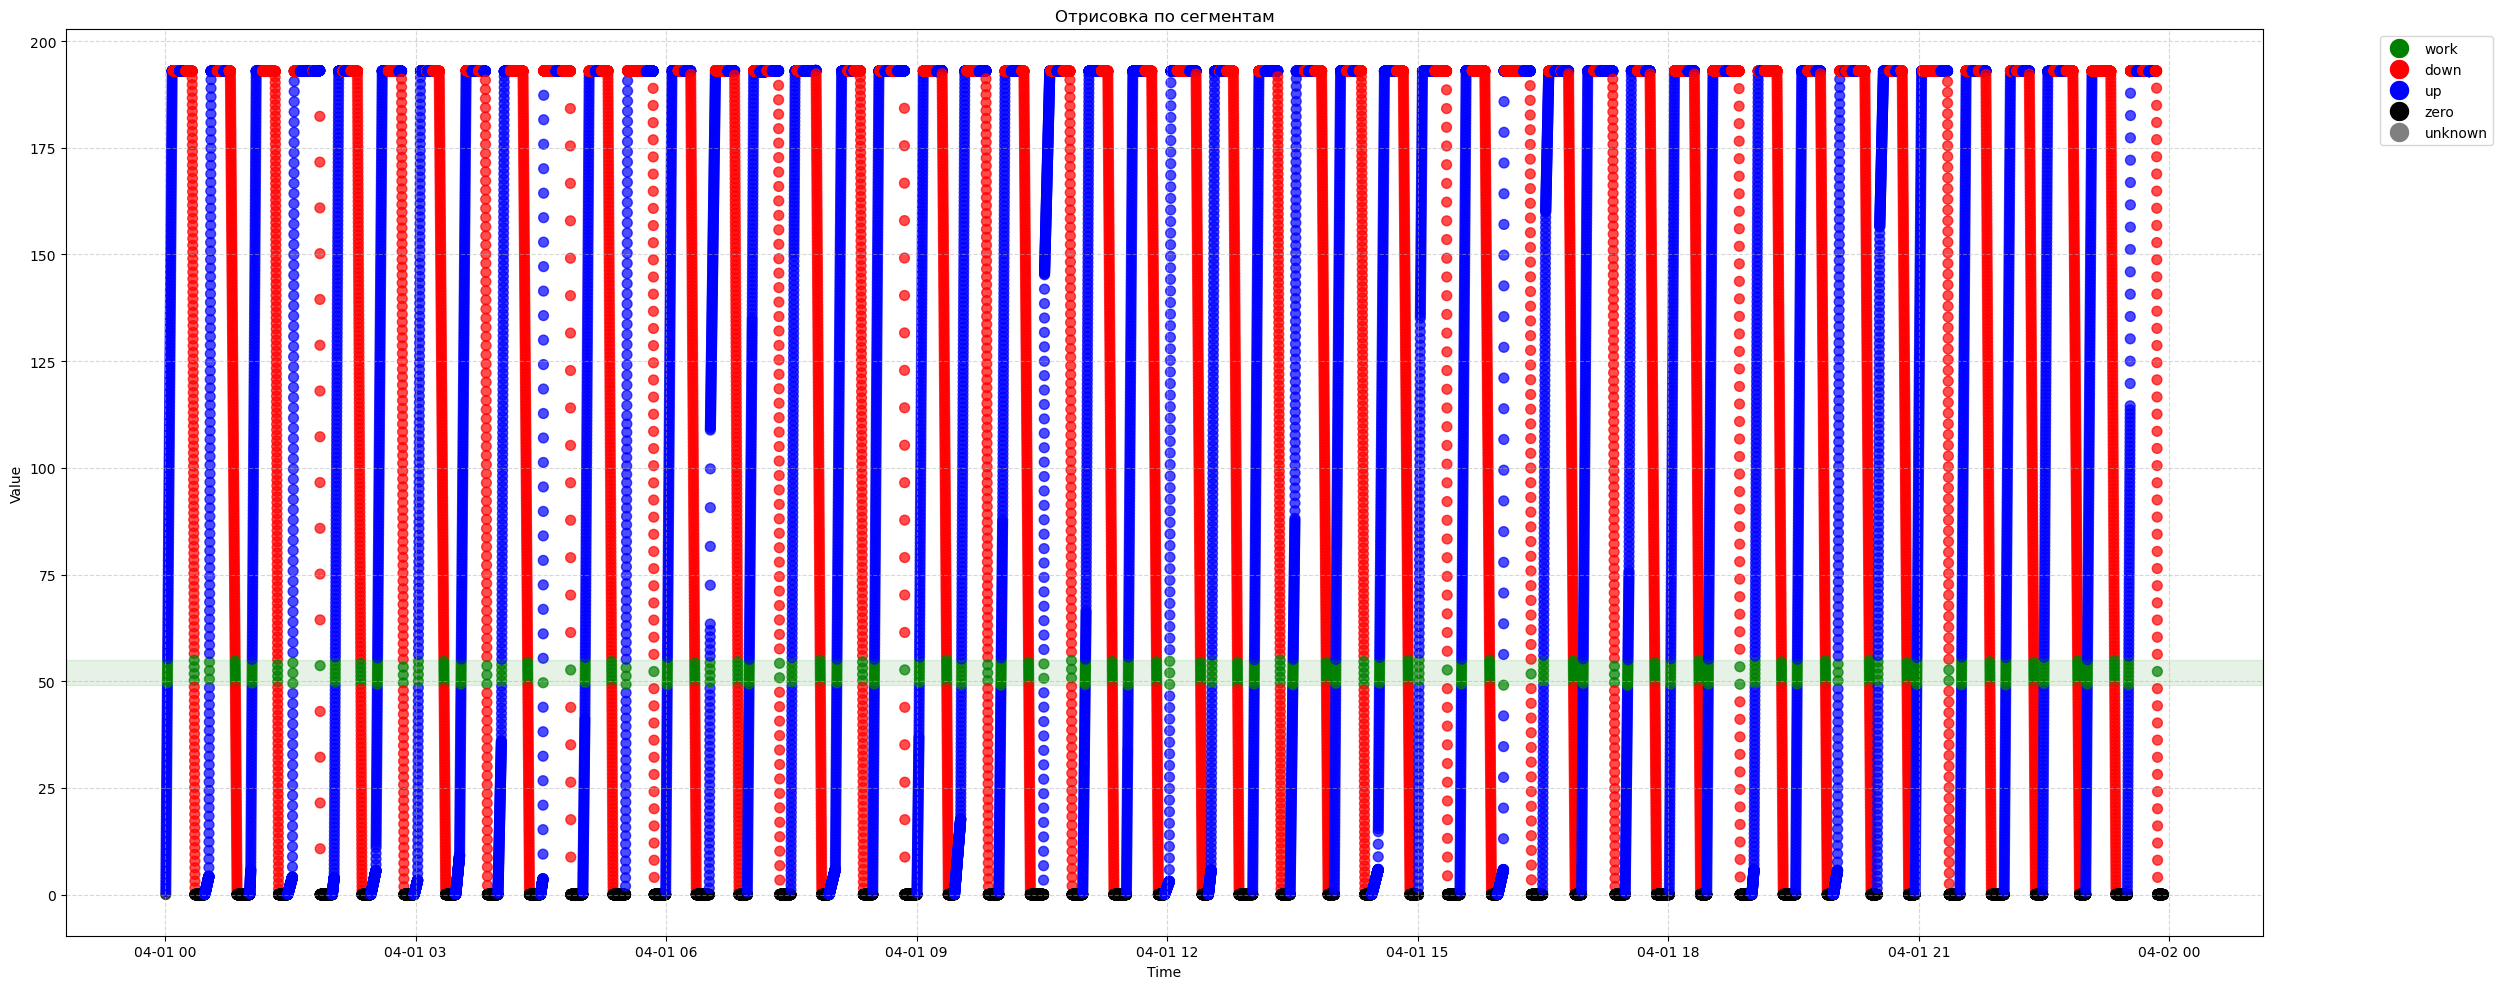

In [204]:
list_of_dfs = data_split(df, well_id_int=2280025600	, param_id_list=[220], package_size=10000, leftcut=0)
result_df = calculate_deviations(list_of_dfs, dict_values = {220: [0,2000]})
df2 = pd.DataFrame()
df2['220_Value'] = result_df[-1][0]['220_Value']
x = df2.index.values
y = df2['220_Value'].values
dat = pd.DataFrame({'value': y}, index=x)
result = PKV_segmentation(dat, 55, 49)
plot_original_points_optimized(dat, result, 49,  55)